# Q7

State of airbnb in london 
- Already a shit ton of airbnbs in london
- Draw on q6

Airbnb has the potential to exacerbate the affordable housing crisis in London by reducing the availability of long-term rentals. The impact of Airbnb is of particular concern with regard to deprived households, whereby increased housing costs can contribute to displacement, making it more difficult for these residents to remain in their communities.

Our analysis aims to answer the following questions: What wards are “at risk” of becoming an Airbnb hotspot? Of these wards, which are also the most vulnerable to the negative social impacts of Airbnb?

## Setting Up

#### Import Packages:

In [34]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
from libpysal.weights import Queen
from esda import Moran
from esda import Moran_Local
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
from matplotlib_scalebar.scalebar import ScaleBar
from sklearn.metrics import confusion_matrix

## Read Data

#### Airbnb data:

In [3]:
airbnb = pd.read_csv("data/20240614-London-listings.csv.gz")

airbnb = gpd.GeoDataFrame(airbnb, 
                       geometry=gpd.points_from_xy(airbnb.longitude, airbnb.latitude), 
                       crs="EPSG:4326").to_crs(epsg=27700)

We cleaned the Airbnb dataset to focus on listings most relevant to neighbourhood impacts:

Minimum Nights: Excluded stays over 30 nights to target short-term rentals.

Recently Active: Included listings with reviews in the past six months for current relevance.

Availability: Kept listings available at least 90 days annually to capture impactful activity.

Room Type: Focused on “Entire home/apt” listings due to their greater effect on housing and neighbourhood dynamics.

In [4]:
from datetime import datetime, timedelta

# Filter min. nights
filtered_airbnb=airbnb[airbnb.minimum_nights<=30]

## To determine recently active sites

# Convert 'last_review' to datetime format
filtered_airbnb.loc[:, 'last_review'] = pd.to_datetime(filtered_airbnb['last_review'], errors='coerce')

# Set the reference date (for reproducibility)
reference_date = datetime(2024, 11, 28)

# Calculate the threshold date (6 months before the reference date)
six_months_ago = reference_date - timedelta(days=6 * 30) 

# Filter the data
filtered_airbnb = filtered_airbnb[filtered_airbnb['last_review'] >= six_months_ago]

filtered_airbnb = filtered_airbnb[filtered_airbnb['availability_365'] >= 90]

filtered_airbnb = filtered_airbnb[filtered_airbnb['room_type'] == "Entire home/apt"]

#### London ward profiles:

In [5]:
ward_profiles = pd.read_csv("data/ward-profiles.csv", encoding="latin1")

# Including only selected variables
ward_profiles = ward_profiles[['Ward name', 'New code','Average Public Transport Accessibility score - 2014','Median House Price (£) - 2014','Median Household income estimate (2012/13)','(ID2010) - Rank of average score (within London) - 2010','(ID2010) % of LSOAs in worst 50% nationally - 2010','Average GCSE capped point scores - 2014',
    '% BAME - 2011','Number of Household spaces - 2011']]


#### Ward geo-data:

In [6]:
wards = gpd.read_file("data/London-wards-2011/London_Ward_CityMerged.shp").to_crs(epsg=27700)[["GSS_CODE","HECTARES","geometry"]]
boroughs = gpd.read_file("data/statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp")


inner_london_boroughs = [
    'Camden', 'Greenwich', 'Hackney', 'Hammersmith and Fulham', 'Islington', 
    'Kensington and Chelsea', 'Lambeth', 'Lewisham', 'Southwark', 'Tower Hamlets', 
    'Wandsworth', 'Westminster', 'City of London'
]
inner_boroughs = boroughs[boroughs['NAME'].isin(inner_london_boroughs)]


#### Import point of interest data from Google Drive:

In [7]:
import subprocess
import sys
import importlib.util

def install_and_import(package):
    try:
        # Check if the package is already installed
        if importlib.util.find_spec(package) is None:
            print(f"{package} not found. Installing...")
            subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        else:
            print(f"{package} is already installed. Skipping installation.")
    except Exception as e:
        print(f"An error occurred while checking or installing {package}: {e}")

install_and_import("gdown")

gdown is already installed. Skipping installation.


link incase this does not work: https://drive.google.com/uc?id=1Abf3I-ez_imd3hzAAmPu8UGcU8dH9lWK

In [8]:
import gdown
import os

# Google Drive file URL and local file destination
file_url = "https://drive.google.com/uc?id=1Abf3I-ez_imd3hzAAmPu8UGcU8dH9lWK"
destination = "London_Points_Of_Interest.gpkg"

# Check if the file already exists
if not os.path.exists(destination):
    print(f"File not found locally. Downloading {destination}...")
    gdown.download(file_url, destination, quiet=False)
    print(f"Downloaded file: {destination}")
else:
    print(f"File already exists: {destination}. Skipping download.")

# Verify file size
print(f"File size: {os.path.getsize(destination)} bytes")

gdf = gpd.read_file(destination)

# Selecting pubs, restaurants, cafes
desired_classes = ["Pubs, Bars and Inns", "Cafes, Snack Bars and Tea Rooms", "Restaurants"]
poi_data = gdf[gdf['classname'].isin(desired_classes)]

File already exists: London_Points_Of_Interest.gpkg. Skipping download.
File size: 129515520 bytes


#### Merging together:

In [9]:
ward_airbnb = wards.merge(ward_profiles, left_on = "GSS_CODE", right_on = "New code", how = "left")

ward_airbnb = gpd.GeoDataFrame(ward_airbnb, crs = "EPSG:27700")

ward_airbnb['Borough'] = ward_airbnb['Ward name'].str.split(' - ').str[0]

#creating poi_density variable
ward_airbnb["n_poi"] = ward_airbnb.geometry.apply(lambda geom: sum(poi_data.geometry.intersects(geom)))
ward_airbnb["poi_density"] = ward_airbnb["n_poi"] / ward_airbnb["HECTARES"]

#intersecting airbnb points and ward data 
#creating airbnb per 1000 households variables
ward_airbnb["n_airbnb"] = ward_airbnb.geometry.apply(lambda geom: sum(filtered_airbnb.geometry.intersects(geom)))
ward_airbnb["airbnb_density"] = ward_airbnb["n_airbnb"] / ward_airbnb["HECTARES"]
#ward_airbnb["airbnb_per_1000"] = (ward_airbnb["n_airbnb"] / ward_airbnb["Population - 2015"])*1000
ward_airbnb["airbnb_per_1000_household"] = (ward_airbnb["n_airbnb"] / ward_airbnb["Number of Household spaces - 2011"])*1000


## Analysis

### Decision tree model:

We chose a decision tree methodology for this analysis due to its high interpretability, making it easy for policymakers to understand how each ward was classified as “at-risk” or “too late”. Each classification decision the model makes can be easily traced in a simple, visual format.


The decision tree predicts whether a ward is likely to have high Airbnb density using ward-level characteristics of  public transport accessibility, house prices, and point of interest density, which we then use to categorise each London ward into one of three groups:

**Too Late**: Wards already heavily impacted by Airbnb, that are in the top 5% of airbnb's per 1000 households. 

**At Risk**: Wards predicted to have high Airbnb density but do not meet the threshold. 

**Neither**: Wards that don't fall into either category. 

We selected these variables as research has shown that higher-income neighborhoods, better transit access, and proximity to attractions significantly influence Airbnb activity (Jiao and Bai, 2020).


In [10]:
# Calculate the 95th quantile for Airbnb density
quantile = np.quantile(ward_airbnb['airbnb_per_1000_household'], 0.95)
print(f"AirBnb Density 'Too-Late' Threshold: {quantile:.3} per 1000 households\n") 


# Create a high Airbnb density indicator
ward_airbnb['high_airbnb_dens'] = ward_airbnb['airbnb_per_1000_household'] >= quantile

print(f"Average Ward AirBnb Density: {ward_airbnb['airbnb_per_1000_household'].mean():.3} per 1000 households ")
print(f"Average Ward House Price: £{ward_airbnb['Median House Price (£) - 2014'].mean():,.0f} ")
print(f"Average Ward Household Income: £{ward_airbnb['Median Household income estimate (2012/13)'].mean():,.0f} ")
print(f"Average Ward Point of Interest Density: {ward_airbnb['poi_density'].mean():.3} ")
print(f"Average Ward Public Transport Accessibility Score: {ward_airbnb['Average Public Transport Accessibility score - 2014'].mean():.3}")


AirBnb Density 'Too-Late' Threshold: 5.63 per 1000 households

Average Ward AirBnb Density: 1.43 per 1000 households 
Average Ward House Price: £434,979 
Average Ward Household Income: £39,303 
Average Ward Point of Interest Density: 0.27 
Average Ward Public Transport Accessibility Score: 3.78


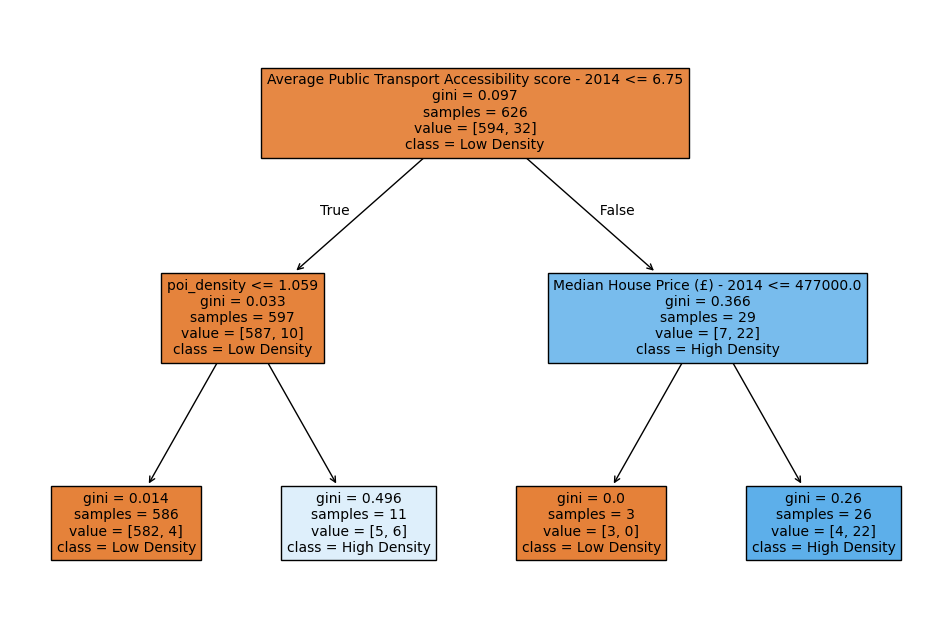

In [11]:
# Prepare data for the decision tree
X = ward_airbnb[['poi_density', 
                 'Average Public Transport Accessibility score - 2014', 
                 'Median House Price (£) - 2014', 
                 'Median Household income estimate (2012/13)']]  # dependent variables
y = ward_airbnb['high_airbnb_dens']

# Train a decision tree
tree = DecisionTreeClassifier(max_depth=2, random_state=42) # limited depth means model remains interpretable without overfitting, focusing on the most critical features.
tree.fit(X, y)

# Plot the decision tree
plt.figure(figsize=(12, 8))
plot_tree(tree, feature_names=X.columns, class_names=['Low Density', 'High Density'], filled=True, fontsize=10)
plt.show()

#### Interpreting the Decision Tree

The decision tree model identifies two scenarios where a ward is predicted to have a high Airbnb density:


- Transport Accessibility of more than 6.75 and a Median House Price of more than £477,000 


**or**
- Transport Accessibility of less than or equal to 6.75 and a point of interest density of more than 1.059 per hectare. 


The results suggest that high Airbnb density is linked to well-connected areas with above-average housing prices, though less connected areas can also attract Airbnb activity if they offer a high concentration of attractions and amenities.


There are 9 wards that meet either of these conditions but do not exceed the ‘too late’ AirBnB density threshold, so these are the wards that we have categorised as ‘at-risk’.


In [13]:
# Add predictions to the GeoDataFrame
ward_airbnb['prediction'] = tree.predict_proba(X)[:, 1] > 0.5

# Generate the at-risk and too-late categories
at_risk = ward_airbnb[(ward_airbnb['high_airbnb_dens'] == False) & (ward_airbnb['prediction'] == True)]
too_late = ward_airbnb[ward_airbnb['high_airbnb_dens'] == True]

ward_airbnb['status'] = 'neither'
ward_airbnb.loc[ward_airbnb['Ward name'].isin(too_late['Ward name']), 'status'] = 'too_late'
ward_airbnb.loc[ward_airbnb['Ward name'].isin(at_risk['Ward name']), 'status'] = 'at_risk'


ward_names = at_risk['Ward name'].tolist()
print(f"These at-risk wards are: {', '.join(ward_names)}")


These at-risk wards are: Lambeth - Bishop's, Hammersmith and Fulham - Shepherd's Bush Green, Westminster - Vincent Square, Westminster - Warwick, Camden - Camden Town with Primrose Hill, Islington - St. Mary's, Islington - Bunhill, Islington - Finsbury Park, Hackney - Dalston


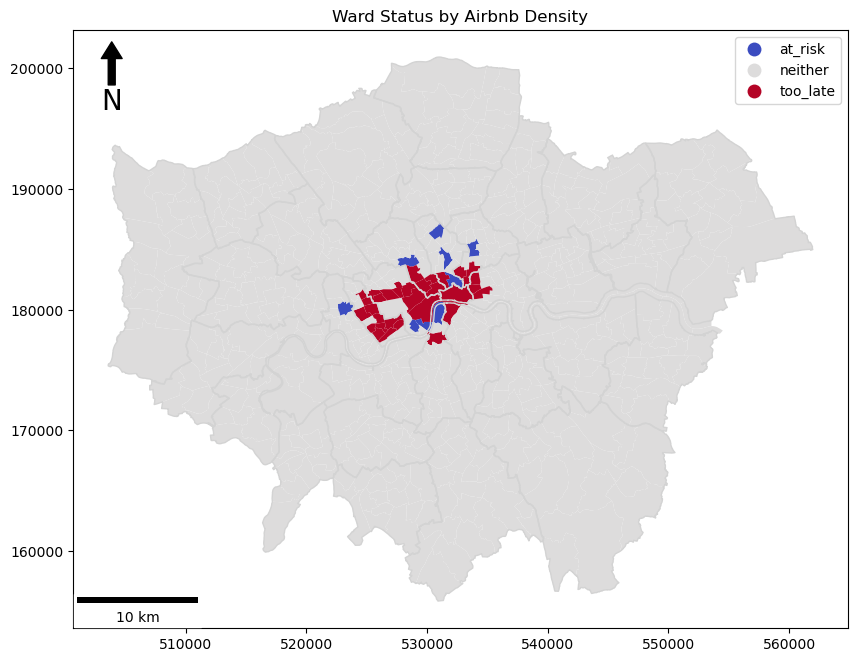

In [35]:
# Visualise at risk wards with a choropleth map
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ward_airbnb.plot(column='status', 
                 legend=True, 
                 cmap='coolwarm', 
                 ax=ax, 
                 legend_kwds={'bbox_to_anchor': (1, 1)})
plt.title("Ward Status by Airbnb Density")

# Add scale bar
scalebar = ScaleBar(1, location='lower left')  # 1 is the length of one pixel, adjust based on map scale
ax.add_artist(scalebar)

# Add North Arrow
x, y, arrow_length = 0.05, 0.98, 0.1
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax.transAxes)

boroughs.plot(
    edgecolor='lightgrey',    
    linewidth=1,         
    ax=ax,
    facecolor='none'      
)
plt.show()

### "At-Risk" wards and deprivation:

To assess potential social impact of Airbnb in London, we analyzed the relationship between our Airbnb decision tree classifications and deprivation rank in wards. Deprivation rank is a relative measure comparing the level of deprivation across London wards. The lower the deprivation rank, the greater the deprivation score in the ward. 

#### EDA:

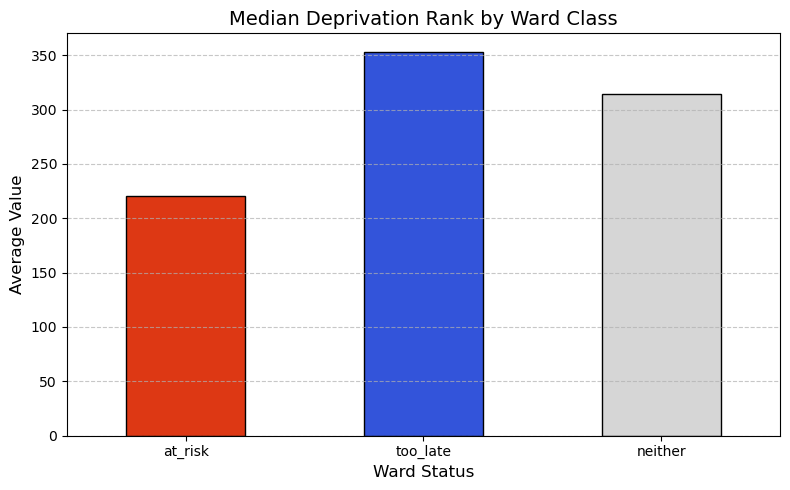

Median Deprivation Rank for 'at-risk' wards: 220.0
Median Deprivation Rank for 'too-late' wards: 352.5


In [26]:
# List of variables to analyze
variables = [
    '(ID2010) - Rank of average score (within London) - 2010']

# Custom order for the categories
category_order = ['at_risk', 'too_late', 'neither']

# Group the data by 'status' and calculate medians
#averages = ward_airbnb.groupby('status')[variables].median()
averages = ward_airbnb.groupby('status')[variables].median()

# Reindex to ensure the correct order of categories
averages = averages.reindex(category_order)

# Create individual bar plots for each variable
for var in variables:
    plt.figure(figsize=(8, 5))
    averages[var].plot(kind='bar', color=['#dd3814', '#3354da', '#d6d6d6'], edgecolor='black')

    # Customize the plot
    plt.title(f'Median Deprivation Rank by Ward Class', fontsize=14)
    plt.ylabel('Average Value', fontsize=12)
    plt.xlabel('Ward Status', fontsize=12)
    plt.xticks(rotation=0, fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Show the plot
    plt.tight_layout()
    plt.show()

print("Median Deprivation Rank for 'at-risk' wards:", averages.loc['at_risk'].iloc[0])
print("Median Deprivation Rank for 'too-late' wards:", averages.loc['too_late'].iloc[0])

We begin with an exploratory data analysis of deprivation and ward classifications. This histogram shows the average deprivation rank between classification types. We see that the mean deprivation rank of “at-risk” wards is lower than “too-late” wards. This suggests that “at-risk” wards are not only desirable to Airbnb letters but are also particularly vulnerable to the negative impacts of Airbnb. 

#### Spatial autocorrelation analysis:

The question remains where overlaps between “at-risk” wards and high deprivation occur. Spatial autocorrelation analysis of deprivation in London wards was employed to assess the spatial distribution of deprived wards and examine which “at-risk” wards lie within high deprivation clusters. Cluster analysis improves the generalizability of the study by identifying patterns of deprivation beyond individual wards with arbitrary boundaries. 

<b>Moran's I:<b>

In [16]:
# Create a spatial weights matrix based on Queen contiguity
w = Queen.from_dataframe(ward_airbnb, use_index=False)

# Ensure the weights are row-standardized
w.transform = 'r'

# Use the variable '(ID2010) - Rank of average score (within London) - 2010' for the Moran test
y = ward_airbnb['(ID2010) - Rank of average score (within London) - 2010'].values

# Calculate Global Moran's I
moran = Moran(y, w)

# Moran's I statistic
moran_I = moran.I
print(f"Global Moran's I: {moran_I}")

# p-value for the test
moran_p_value = moran.p_sim
print(f"p-value: {moran_p_value}")

Global Moran's I: 0.6888600665914413
p-value: 0.001


A Moran’s I test is conducted to establish that deprivation is not randomly distributed across wards in London. A Global Moran’s I statistic of 0.689 with a p-value less than 0.05 indicates there is statistically significant clustering of deprivation in London wards.

<b>LISA:<b>

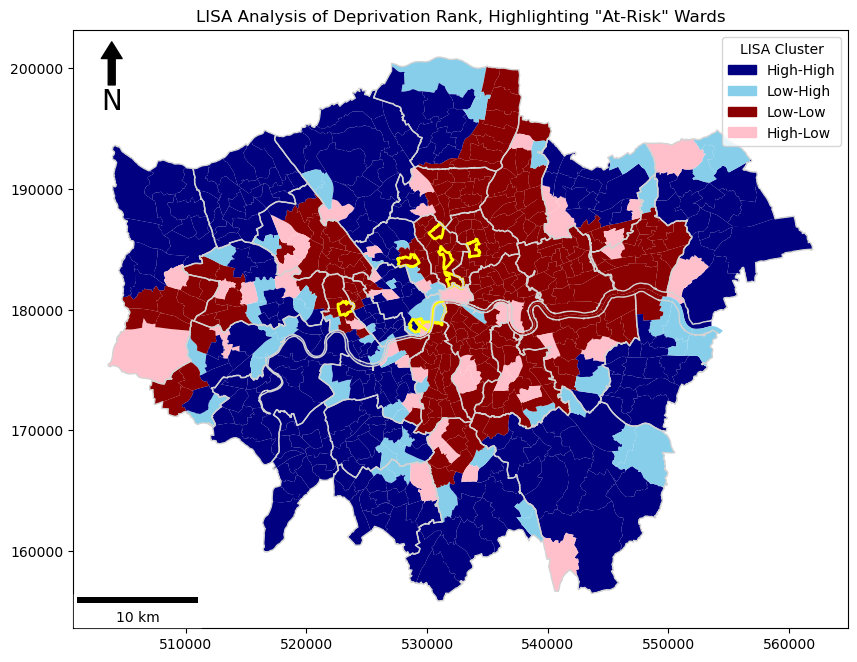

In [37]:
# Ensure the weights are row-standardized
w.transform = 'r'

# Use the vulnerability variable for LISA analysis
y = ward_airbnb['(ID2010) - Rank of average score (within London) - 2010'].values

# Calculate Local Moran's I
lisa = Moran_Local(y, w)

# Add the LISA statistics to the GeoDataFrame
ward_airbnb['moran_local'] = lisa.Is
ward_airbnb['p_value'] = lisa.p_sim
ward_airbnb['quadrant'] = lisa.q

# Identify significant clusters at 0.05 level
ward_airbnb['significant'] = ward_airbnb['p_value'] < 0.05

# Define custom colormap for the LISA quadrants
custom_cmap = ListedColormap(['navy', 'skyblue', 'darkred', 'pink'])  # Soft dark red, soft light blue, soft dark blue, soft light red

# Plot the LISA results
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Use 'quadrant' for the categorical color mapping
ward_airbnb.plot(
    column='quadrant',  # Use 'quadrant' for discrete categories
    cmap=custom_cmap,    # Apply the custom colormap
    ax=ax,
    legend=False         # Disable the color bar
)

# Outline the wards with 'at_risk' status
at_risk_wards = ward_airbnb[ward_airbnb['status'] == 'at_risk']
at_risk_wards.plot(
    edgecolor='yellow',    # Set black boundary for at-risk wards
    linewidth=2,          # Thicker line width for visibility
    ax=ax,
    facecolor='none'      # No fill color, just outlines
)

# Outline the wards with 'at_risk' status
boroughs.plot(
    edgecolor='lightgrey',    # Set black boundary for at-risk wards
    linewidth=1,          # Thicker line width for visibility
    ax=ax,
    facecolor='none'      # No fill color, just outlines
)

# Manually create legend with cluster labels
legend_labels = ['High-High', 'Low-High', 'Low-Low', 'High-Low']
colors = custom_cmap(range(4))  # Get colors from the custom colormap

# Add the custom legend to the plot
legend_elements = [Patch(color=colors[i], label=legend_labels[i]) for i in range(4)]
ax.legend(handles=legend_elements, title='LISA Cluster')

# Add scale bar
scalebar = ScaleBar(1, location='lower left')  # 1 is the length of one pixel, adjust based on map scale
ax.add_artist(scalebar)

# Add North Arrow
x, y, arrow_length = 0.05, 0.98, 0.1
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax.transAxes)

plt.title('LISA Analysis of Deprivation Rank, Highlighting "At-Risk" Wards')
plt.show()

Local indicators of spatial autocorrelation (LISA) statistics allow us to visualize the clustering of deprivation in London. Outlining “at-risk” wards  in yellow, we see an overlap of deprivation clustering and “at-risk” classification for three wards in Islington, one in Hackney, one in Camden, and one in Hammersmith and Fulham. 

# Conclusion

The study concludes there are 9 wards “at-risk” of becoming heavily saturated by Airbnb. Furthermore, six of these wards are located within clusters of high deprivation. City policy should focus on better regulating and limiting Airbnbs in the the boroughs of Islington, Hackney, and Hammersmith and Fulham to mitigate the negative impacts of Airbnb on vulnerable populations. 